In [1]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

# 이미지 및 라벨 경로 설정
image_dir = "/root/staircase/images"
label_dir = "/root/staircase/images"  # 레이블 파일이 이미지와 동일한 경로에 있다고 하셨으므로 수정


image_paths = []
labels = []

# 이미지 디렉토리 내의 모든 파일에 대해 반복
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))

        # 레이블 파일이 존재하는지 확인
        if os.path.exists(label_path):
            # 레이블 파일의 크기가 0인지 확인 (비어있는 파일)
            if os.path.getsize(label_path) == 0:
                print(f"{label_path} is empty. No objects detected.")
                label = 0  # 계단 없음
            else:
                with open(label_path, "r") as f:
                    content = f.read()
                    # 클래스 번호 목록 초기화
                    class_numbers = []

                    for line in content.strip().split("\n"):
                        line = line.strip()
                        if line:
                            tokens = line.split()
                            if len(tokens) > 0:
                                class_number = tokens[0]
                                class_numbers.append(class_number)

                    # 클래스 '2'(계단)가 있는지 확인
                    if "1" in class_numbers:
                        print(f"Stair detected in {label_path}")
                        label = 1  # 계단 있음
                    else:
                        label = 0  # 계단 없음
        else:
            print(f"Label file not found for {filename}")
            label = 0  # 레이블 파일이 없으면 계단 없음으로 처리

        image_paths.append(image_path)
        labels.append(label)

# 데이터프레임 생성
df = pd.DataFrame({"image": image_paths, "label": labels})

# 학습 및 검증 세트로 분할
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

ModuleNotFoundError: No module named 'pandas'

In [22]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# 데이터 변환 설정
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
}


class StaircaseDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, "image"]
        label = self.df.loc[idx, "label"]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# 데이터셋 생성
train_dataset = StaircaseDataset(train_df, transform=data_transforms["train"])
val_dataset = StaircaseDataset(val_df, transform=data_transforms["val"])

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [23]:
import torch.nn as nn
import torch.optim as optim

# 사전 학습된 ResNet18 모델 로드
model = models.resnet18(pretrained=True)

# 출력 레이어 수정 (이진 분류)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 루프
num_epochs = 10
model = model.to("cuda")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda").float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

/root/anaconda3/envs/staircase/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/staircase/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.1738786970953538
Epoch 2/10, Loss: 0.10565458841382135
Epoch 3/10, Loss: 0.11286544822477944
Epoch 4/10, Loss: 0.0753143638508089
Epoch 5/10, Loss: 0.06159125617804016
Epoch 6/10, Loss: 0.06388911654223495
Epoch 7/10, Loss: 0.04912372019971716
Epoch 8/10, Loss: 0.050608368803732824
Epoch 9/10, Loss: 0.03997544008317613
Epoch 10/10, Loss: 0.04452186424250792


In [24]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda").float().unsqueeze(1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.9810568295114656


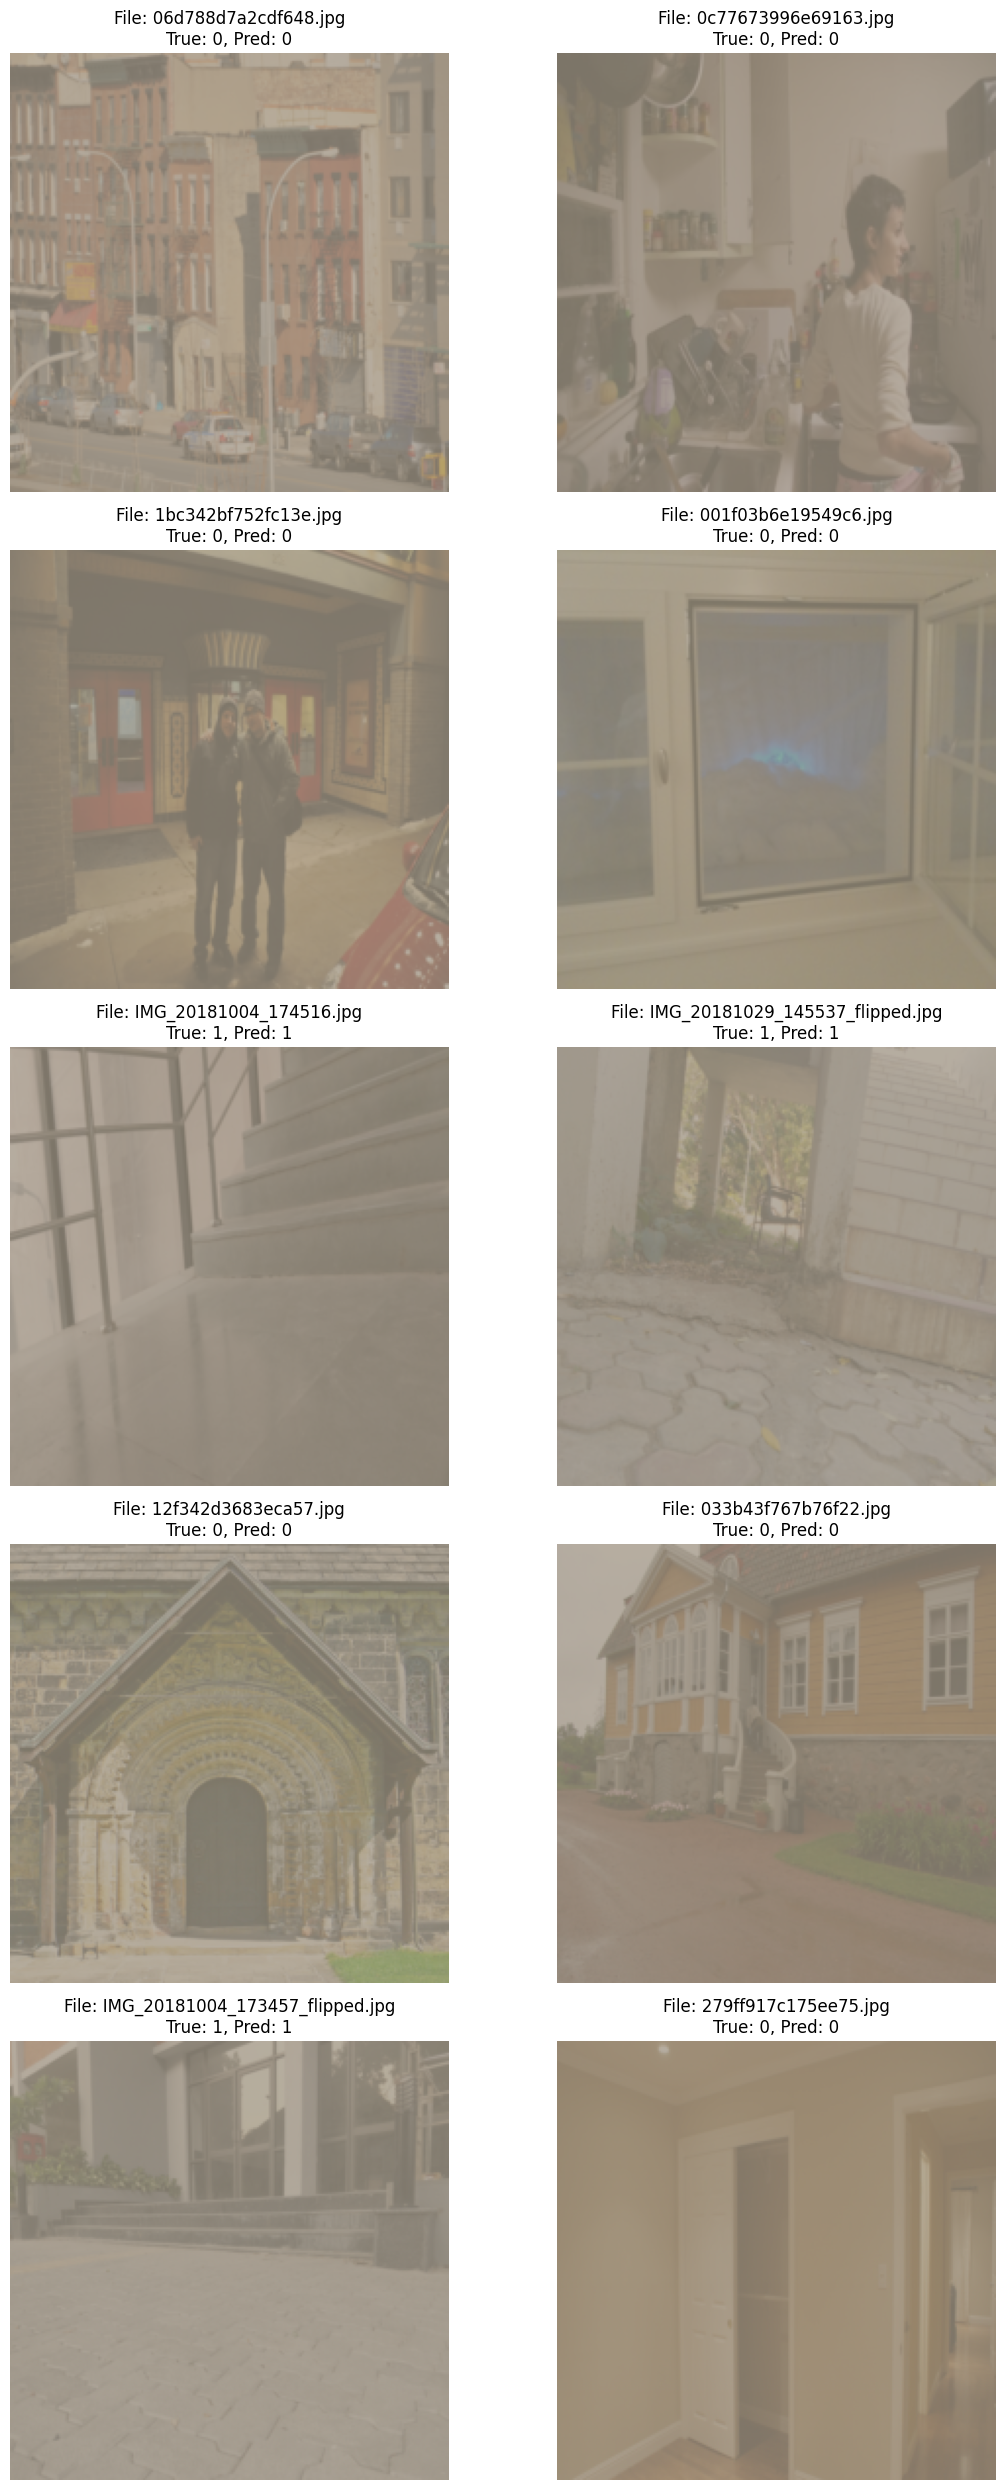

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델을 평가 모드로 전환
model.eval()

# 검증 데이터셋에서 랜덤하게 10장의 이미지 선택
example_indices = np.random.choice(len(val_dataset), size=10, replace=False)

# 이미지와 레이블을 저장할 리스트 초기화
images = []
true_labels = []
predicted_labels = []
file_names = []

# 예시 이미지에 대해 예측 수행
with torch.no_grad():
    for idx in example_indices:
        image, label = val_dataset[idx]
        inputs = image.unsqueeze(0).to("cuda")  # 'cuda' 대신 'device' 사용
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        predicted_label = preds.item()

        images.append(image.cpu())
        true_labels.append(label)
        predicted_labels.append(int(predicted_label))

        # 파일 이름 가져오기
        file_path = val_df.iloc[idx]["image"]
        file_name = os.path.basename(file_path)
        file_names.append(file_name)


# 이미지 표시 함수 수정
def imshow(inp, title=None, ax=None):
    """Tensor 이미지를 보여주는 함수"""
    if ax is None:
        ax = plt.gca()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet 평균값
    std = np.array([0.229, 0.224, 0.225])  # ImageNet 표준편차
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title:
        ax.set_title(title)
    ax.axis("off")


# 서브플롯 생성 및 이미지 출력 (2열 5행 배열)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))

axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(images):
        imshow(
            images[idx],
            title=f"File: {file_names[idx]}\nTrue: {true_labels[idx]}, Pred: {predicted_labels[idx]}",
            ax=ax,
        )
    else:
        ax.axis("off")  # 남은 서브플롯 비활성화

plt.tight_layout()
plt.show()

In [29]:
import os

# 모델 저장 경로 설정
model_dir = "/root/staircase/models"
os.makedirs(model_dir, exist_ok=True)

# 모델 저장 경로 설정
model_save_path = os.path.join(model_dir, "resnet18_staircase.pth")

# 모델 저장
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /root/staircase/models/resnet18_staircase.pth
